In [1]:
# -*- coding: utf-8 -*-
import zipfile
import os
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report,roc_curve,auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_svmlight_file
import time

In [2]:
#获取当前目录
data_root = os.getcwd()
dfData = pd.read_table("%s/train.raw.20181105"%data_root) #加载原始训练数据（未做one-hot和离散化处理）
dfData

,user_id,ctype,cid,dt,isclk,uimp,uclk,dimp,dclk,gender,location,hasbaby,babybirthday,babygender,createtime,key_tag
0,414395,1,81917323,2018-11-01,1,162,9,3905,236,female,3201.0,preg,2019-03-07,none,2018-02-01,5921
1,414395,1,81409364,2018-10-30,0,162,9,3101,48,female,3201.0,preg,2019-03-07,none,2018-01-09,"3892,1513"
2,414395,28,343449,2018-10-30,1,162,9,103350,20293,female,3201.0,preg,2019-03-07,none,2018-01-01,NaN
3,6460683,28,342031,2018-10-29,0,23,0,1941811,26702,NaN,1101.0,preg,2019-01-19,none,2018-10-24,"273,5121,246,5017,4893"
4,6935403,1,81786097,2018-10-27,1,106,3,74023,10168,NaN,3303.0,true,2018-10-08,boy,2018-01-26,"273,2723,3322,2643"
5,7370561,28,344350,2018-11-02,0,138,4,555390,46,NaN,3411.0,preg,2019-04-04,none,2018-11-02,NaN
6,7370561,1,87244700,2018-11-02,0,138,4,6,0,NaN,3411.0,preg,2019-04-04,none,2018-11-02,7071
7,7370561,28,343342,2018-10-29,0,138,4,445311,10108,NaN,3411.0,preg,2019-04-04,none,2018-10-26,"500,4006,296,3611,1018,2782,2589"
8,7370561,28,343046,2018-10-27,0,138,4,2474733,610,NaN,3411.0,preg,2019-04-04,none,2018-10-25,"7513,5181"
9,7577563,28,343468,2018-10-30,0,217,1,481600,3658,NaN,3202.0,preg,2019-05-01,none,2018-01-01,NaN


In [3]:
hotData = dfData[['user_id','ctype','cid','isclk','babybirthday','createtime']] #选取几列
hotData

,user_id,ctype,cid,isclk,babybirthday,createtime
0,414395,1,81917323,1,2019-03-07,2018-02-01
1,414395,1,81409364,0,2019-03-07,2018-01-09
2,414395,28,343449,1,2019-03-07,2018-01-01
3,6460683,28,342031,0,2019-01-19,2018-10-24
4,6935403,1,81786097,1,2018-10-08,2018-01-26
5,7370561,28,344350,0,2019-04-04,2018-11-02
6,7370561,1,87244700,0,2019-04-04,2018-11-02
7,7370561,28,343342,0,2019-04-04,2018-10-26
8,7370561,28,343046,0,2019-04-04,2018-10-25
9,7577563,28,343468,0,2019-05-01,2018-01-01


In [4]:
dfData.info() #数据概览

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1438299 entries, 0 to 1438298
Data columns (total 16 columns):
user_id         1438299 non-null int64
ctype           1438299 non-null int64
cid             1438299 non-null int64
dt              1438299 non-null object
isclk           1438299 non-null int64
uimp            1438299 non-null int64
uclk            1438299 non-null int64
dimp            1438299 non-null int64
dclk            1438299 non-null int64
gender          146671 non-null object
location        1437399 non-null float64
hasbaby         1437550 non-null object
babybirthday    1438145 non-null object
babygender      1246363 non-null object
createtime      1438299 non-null object
key_tag         1040731 non-null object
dtypes: float64(1), int64(8), object(7)
memory usage: 175.6+ MB


/Users/jieweiwang/anaconda2/lib/python2.7/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


('Number of clk: ', 318683)
('Number of noclk : ', 1119616)


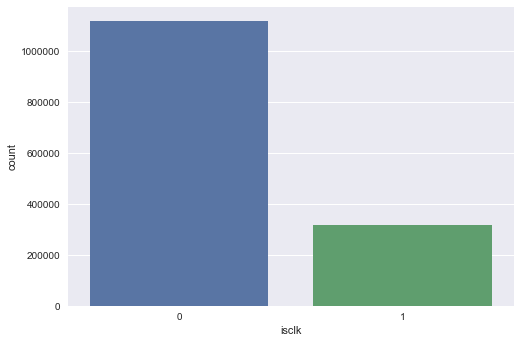

In [5]:
# 正负样本数量
y=dfData.isclk
ax = sns.countplot(y,label="Count") 
noclk, clk = y.value_counts()
print('Number of clk: ',clk)
print('Number of noclk : ',noclk)
plt.show()

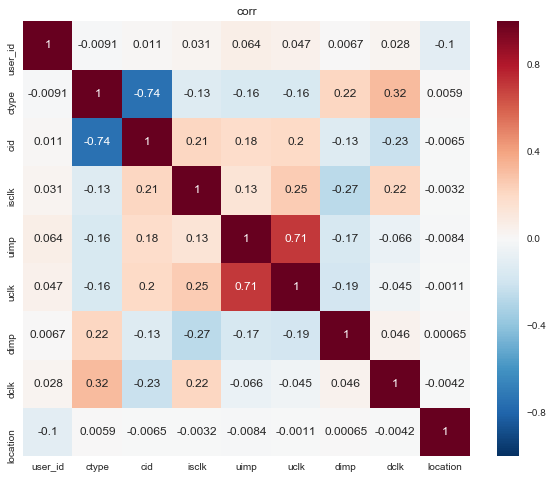

In [6]:
#特征相关度
columns = list(dfData.columns)
plt.subplots(figsize = (10, 8))
sns.heatmap(dfData[columns].corr(), annot=True)
plt.title("corr")
plt.show()

In [7]:
dfData.describe() #数据统计分布

,user_id,ctype,cid,isclk,uimp,uclk,dimp,dclk,location
count,1.438299e+06,1.438299e+06,1.438299e+06,1.438299e+06,1.438299e+06,1.438299e+06,1.438299e+06,1.438299e+06,1.437399e+06
mean,7.141211e+07,1.682071e+01,2.307380e+07,2.215694e-01,1.728431e+02,9.819021e+00,7.178942e+05,8.160991e+03,3.029363e+03
std,1.395160e+07,1.284072e+01,3.613882e+07,4.153029e-01,2.596442e+02,2.743777e+01,9.731957e+05,1.789363e+04,1.956518e+03
min,7.740200e+04,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,6.875017e+07,2.000000e+00,3.270240e+05,0.000000e+00,4.900000e+01,0.000000e+00,2.387300e+04,2.040000e+02,1.301000e+03
50%,7.695032e+07,2.800000e+01,3.432390e+05,0.000000e+00,9.500000e+01,2.000000e+00,3.237010e+05,6.630000e+02,3.502000e+03
75%,8.025762e+07,2.800000e+01,7.081480e+07,0.000000e+00,1.930000e+02,9.000000e+00,1.014122e+06,7.070000e+03,4.403000e+03
max,5.000004e+08,2.800000e+01,1.887040e+08,1.000000e+00,6.146000e+03,8.080000e+02,3.323731e+06,1.002600e+05,9.553000e+03


/Users/jieweiwang/anaconda2/lib/python2.7/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


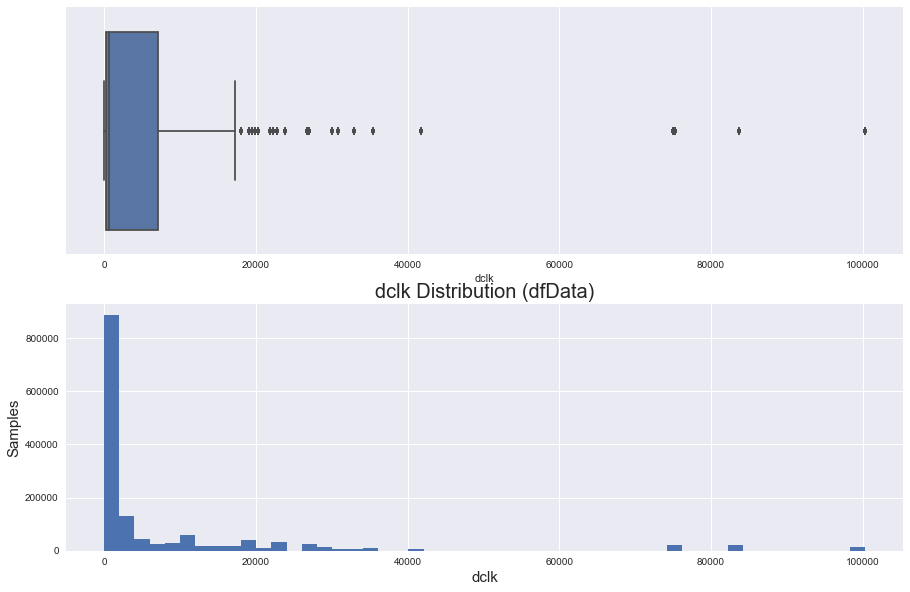

In [8]:
#文章点击数量原始分布
fig, ax = plt.subplots(2, 1, figsize = (15, 10))
sns.boxplot(dfData['dclk'], ax = ax[0])
ax[1].hist(dfData['dclk'], bins = 50)
ax[1].set_title("dclk Distribution (dfData)", fontsize = 20)
ax[1].set_xlabel("dclk", fontsize = 15)
ax[1].set_ylabel("Samples", fontsize = 15)
plt.show()

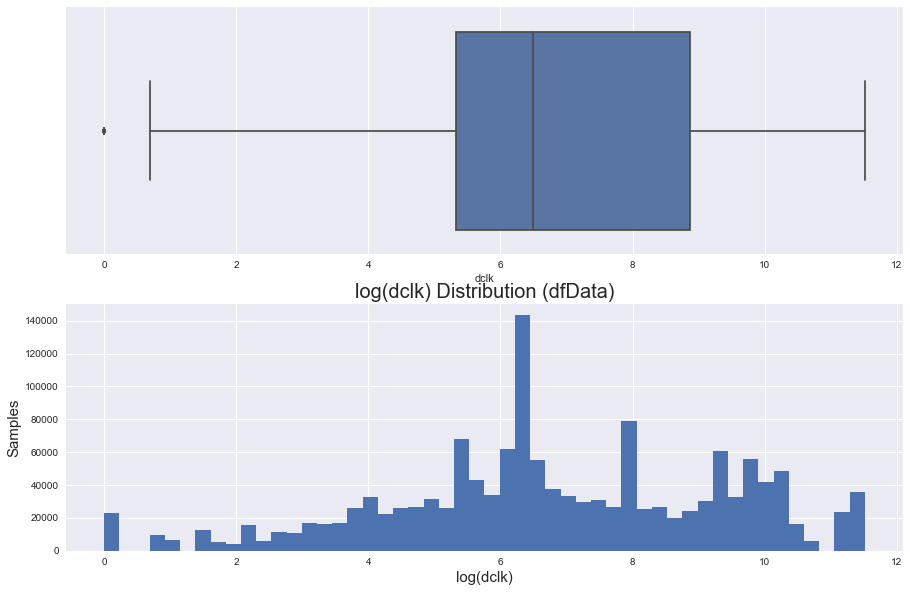

In [9]:
#文章点击数量log分布
dfData["dclk"] = np.log(dfData["dclk"] + 1)
fig, ax = plt.subplots(2, 1, figsize = (15, 10))
sns.boxplot(dfData['dclk'], ax = ax[0])
ax[1].hist(dfData['dclk'], bins = 50)
ax[1].set_title("log(dclk) Distribution (dfData)", fontsize = 20)
ax[1].set_xlabel("log(dclk)", fontsize = 15)
ax[1].set_ylabel("Samples", fontsize = 15)
plt.show()

In [10]:
#加载libsvm格式的训练数据（已经离散化和one-hot好）
x_raw, y_raw = load_svmlight_file("libsvm.train.dat.20181105")

In [11]:
#切分训练集和验证集
X_train,X_test,y_train,y_test = train_test_split(x_raw, y_raw)

In [12]:
#初始化LR回归类
lr = LogisticRegression() # 高版本的默认solver是lbfgs
lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [13]:
#初始化LR回归类：默认L2正则化
#lr = LogisticRegression(penalty='l1',solver='lbfgs')  #l1正则化是非凸函数，优化方法solver只能用liblinear
lr = LogisticRegression(penalty='l2',solver='lbfgs')
lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [14]:
# 训练模型
start_time = time.time()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
time.time() - start_time  #L2正则化 + lbfgs优化时间

12.385292053222656

In [15]:
# 预测验证集
answer = lr.predict_proba(X_test)[:,1]  
answer

array([ 0.24442929,  0.06530799,  0.51242888, ...,  0.05934587,
        0.00104606,  0.00648544])

In [16]:
# 验证集效果评估：混淆矩阵
precision, recall, thresholds = precision_recall_curve(y_test, answer)      
report = answer > 0.5  
print(classification_report(y_test, report, target_names = ['neg', 'pos']))  

             precision    recall  f1-score   support

        neg       0.89      0.91      0.90    280033
        pos       0.66      0.61      0.63     79428

avg / total       0.84      0.85      0.84    359461



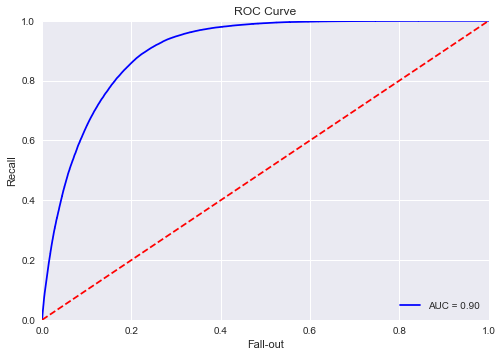

In [17]:
# ROC曲线
false_positive_rate, recall, thresholds = roc_curve(y_test, answer)
roc_auc=auc(false_positive_rate,recall)
plt.title('ROC Curve')
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out')
plt.show()

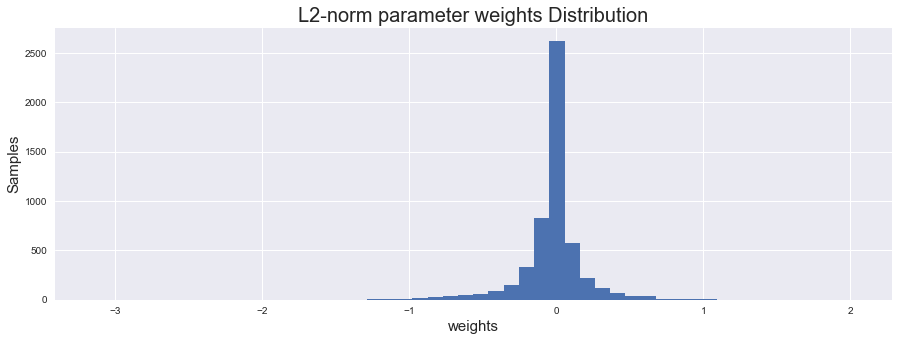

In [18]:
#LR模型参数值分布
fig, ax = plt.subplots(1, 1, figsize = (15, 5))
ax.hist(lr.coef_[0], bins = 50)
ax.set_title("L2-norm parameter weights Distribution", fontsize = 20)
ax.set_xlabel("weights", fontsize = 15)
ax.set_ylabel("Samples", fontsize = 15)
plt.show()

In [19]:
#用L1正则化声明LR回归类
lr_L1norm = LogisticRegression(penalty='l1')
lr_L1norm

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [20]:
# 加了L1正则化训练模型
start_time = time.time()
lr_L1norm.fit(X_train, y_train)
y_pred_l1 = lr_L1norm.predict(X_test)
time.time() - start_time

216.5509090423584

In [21]:
# 预测验证集
answer_l1 = lr_L1norm.predict_proba(X_test)[:,1]  
answer_l1

array([ 0.25322372,  0.06451244,  0.5094768 , ...,  0.0579472 ,
        0.00109877,  0.00714556])

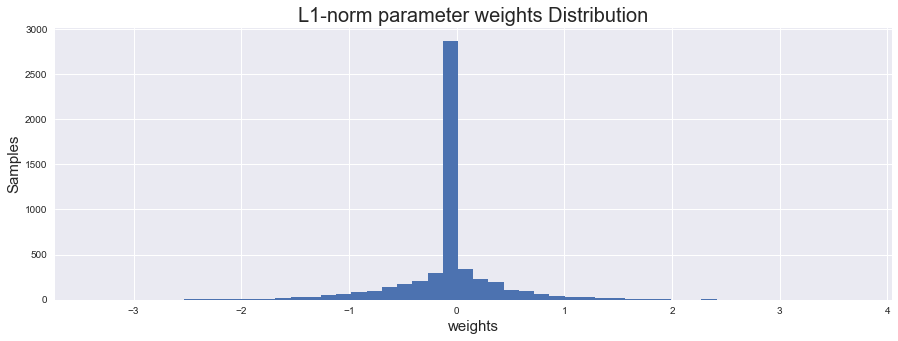

In [22]:
# L1参数值分布
fig, ax = plt.subplots(1, 1, figsize = (15, 5))
ax.hist(lr_L1norm.coef_[0], bins = 50)
ax.set_title("L1-norm parameter weights Distribution", fontsize = 20)
ax.set_xlabel("weights", fontsize = 15)
ax.set_ylabel("Samples", fontsize = 15)
plt.show()

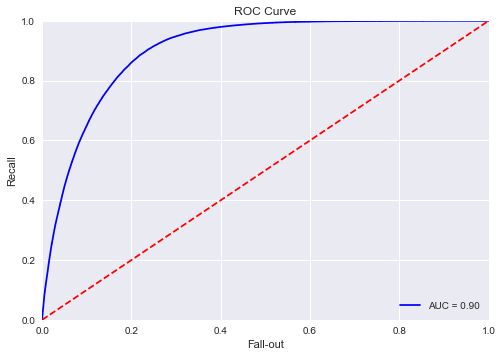

In [23]:
# L1正则化ROC曲线
false_positive_rate, recall, thresholds = roc_curve(y_test, answer_l1)
roc_auc=auc(false_positive_rate,recall)
plt.title('ROC Curve')
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out')
plt.show()

In [24]:
precision, recall, thresholds = precision_recall_curve(y_test, answer_l1)      
report = answer_l1 > 0.5  
print(classification_report(y_test, report, target_names = ['neg', 'pos']))  

             precision    recall  f1-score   support

        neg       0.89      0.91      0.90    280033
        pos       0.66      0.61      0.64     79428

avg / total       0.84      0.85      0.84    359461

